In [1]:
import os
if not 'id_0123456789876543210' in locals():
    os.chdir(os.path.split(os.getcwd())[0])
    id_0123456789876543210 = None

In [2]:
from src.python.optimize.solution import intBinary, floatBinary, ndSolution, Category
from src.python.optimize.search import SearchSpace, MarkovGeneticSearch, LocalSearch
from src.python.training.validation import Foldify, eval_model
from src.python.model import model_v1, model_v1_hparams
import matplotlib.pyplot as plt
import pickle


plt.style.use('ggplot')

def save_object(obj, file):
    with open(file, "wb") as file:
        pickle.dump(obj, file)

def load_object(file):
    with open(file, "rb") as file:
        loaded_object = pickle.load(file)
    return loaded_object

width = 6
high = width / 1.61803

version `datos.modelo.search.seed`

# Graves

In [3]:
data = load_object(
    'data/covid/classification/dataset/train.graves-1.pkl')

## A) version 1.1

### SearchSpace 1

In [4]:
class SearchSpace_1(SearchSpace):
    def __init__(self, input_dim, seed=None) -> None:
        solution = ndSolution(
            input_dim=intBinary(input_dim, input_dim),
            architecture=ndSolution(Category({True, False}), dimension=3),
            neurons=ndSolution(intBinary(1, 2**8, digits=0), dimension=3),
            optimizer=Category({'Adam', 'Nadam', 'RMSprop', 'SGD'}),
            learning_rate=floatBinary(0, 0.01, digits=5),  # x > 0
            momentum=floatBinary(0, 1, digits=3),
            activation=Category({'ELU', 'LeakyReLU'}),
            activation_alpha=floatBinary(0, 0.5, digits=4),
            initializer=Category({'uniform', 'normal'}),
            batch_size=intBinary(2**3, 2**8, digits=0),
            epochs=intBinary(2**5, 2**7, digits=0),
            batch_normalization=Category({True, False}),
            regularization=Category({'l1', 'l2', 'None'}),
            regularization_factor=floatBinary(0, 0.1, digits=4),
            dropout_rate=floatBinary(0, 0.5, digits=4))
        super().__init__(solution, seed)

    def is_feasible(self, x):
        arch = self.solution[1].decode(x[1])
        return (
            # architecture
            arch[0] > 0 and
            all(x >= y for x, y in zip(arch, arch[1:])) and
            # learning_rate
            self.solution[4].decode(x[4]) > 0)

search_space = SearchSpace_1(input_dim=10)

### version 1.1.1.555

In [5]:
VERSION = '1.1.1'
seed = 555
foldify = Foldify.Random(14541,
                         nfolds=6,
                         val_prop=0.2,
                         sorted=True,
                         weight=data['sample'],
                         group=data['label'],
                         seed=seed,
                         datasets=(data['x'], data['y']))

eval_session = load_object(
    f'data/covid/classification/session/eval.graves-{VERSION}.{seed}.pkl')


def objetive(**hparam):
    return eval_model(model_v1,
                      hparam=model_v1_hparams(**hparam),
                      foldify=foldify,
                      infile=eval_session,
                      verbose=1)['summary']['val_mae']


search = MarkovGeneticSearch(objetive,
                             search_space,
                             entropy_limit=0.05,
                             initial=(10, 1000),
                             timemax=0,
                             seed=seed,
                             argstype='kwargs',
                             infile=f'data/covid/classification/session/search.graves-{VERSION}.{seed}.pkl',
                             verbose=0)
print(search.__repr__())
history = search.session.history
iter_history = search.session.iter_history.set_index('neval')

Session loaded from 'data/covid/classification/session/search.graves-1.1.1.555.pkl'.
session:
time                                                 34620.418993
niter                                                          15
neval                                                         150
fmin                                                      0.07618
xmin            [, [True, True, False], [11111010, 01101001, 0...
history                      time  niter      fmin        fx  ...
iter_history                time  niter  neval      fmin     f...
dtype: object


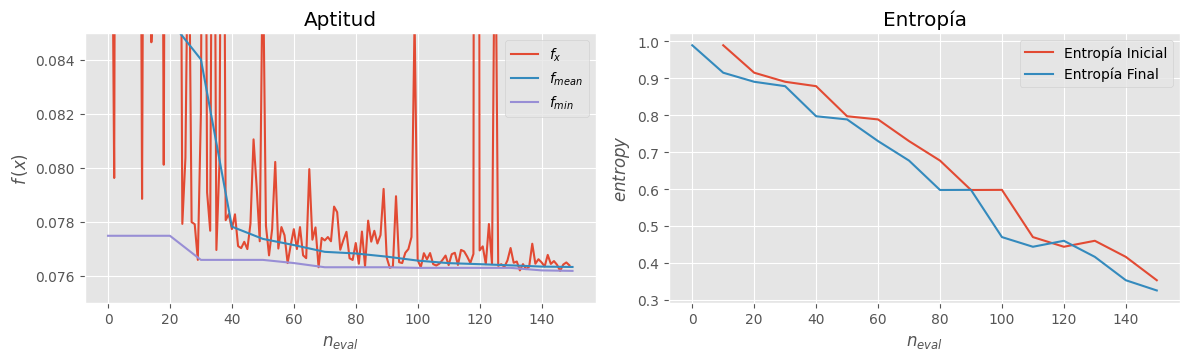

In [6]:
plt.figure(figsize=(2 * width, 1 * high))

plt.subplot(1, 2, 1)
plt.plot(history.fx, label='$f_{x}$')
plt.plot(iter_history.fmean, label ='$f_{mean}$')
plt.plot(iter_history.fmin, label ='$f_{min}$')
plt.ylim((0.075,0.085))
plt.legend()
plt.ylabel('$f\,(x)$')
plt.xlabel('$n_{eval}$')
plt.title('Aptitud')
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.plot(iter_history.initial_entropy, label='Entropía Inicial')
plt.plot(iter_history.final_entropy, label='Entropía Final')
plt.legend()
plt.ylabel('$entropy$')
plt.xlabel('$n_{eval}$')
plt.title('Entropía')
plt.tight_layout()
plt.show()